In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
import warnings

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df = pd.read_csv('hitters.csv')

In [4]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.00,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.00,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.00,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.50,N


## Genel Resim

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [6]:
check_df(df)

##################### Shape #####################
(322, 20)
##################### Types #####################
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
##################### Head #####################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    32

In [7]:
df.columns = [col.upper() for col in df.columns]

In [8]:
df.columns 

Index(['ATBAT', 'HITS', 'HMRUN', 'RUNS', 'RBI', 'WALKS', 'YEARS', 'CATBAT',
       'CHITS', 'CHMRUN', 'CRUNS', 'CRBI', 'CWALKS', 'LEAGUE', 'DIVISION',
       'PUTOUTS', 'ASSISTS', 'ERRORS', 'SALARY', 'NEWLEAGUE'],
      dtype='object')

## Numerik ve Kategorik Değişkenlerin Yakalanması

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [10]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


In [11]:
cat_cols

['LEAGUE', 'DIVISION', 'NEWLEAGUE']

In [12]:
num_cols

['ATBAT',
 'HITS',
 'HMRUN',
 'RUNS',
 'RBI',
 'WALKS',
 'YEARS',
 'CATBAT',
 'CHITS',
 'CHMRUN',
 'CRUNS',
 'CRBI',
 'CWALKS',
 'PUTOUTS',
 'ASSISTS',
 'ERRORS',
 'SALARY']

## Numerik ve Kategorik Değişkenlerin Analizi

In [13]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [14]:
for col in cat_cols:
    cat_summary(df, col)

   LEAGUE  Ratio
A     175  54.35
N     147  45.65
##########################################
   DIVISION  Ratio
W       165  51.24
E       157  48.76
##########################################
   NEWLEAGUE  Ratio
A        176  54.66
N        146  45.34
##########################################


In [15]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

count   322.00
mean    380.93
std     153.40
min      16.00
5%      161.00
10%     194.10
20%     221.80
30%     281.30
40%     321.80
50%     379.50
60%     430.20
70%     490.00
80%     535.60
90%     584.90
95%     609.90
99%     658.59
max     687.00
Name: ATBAT, dtype: float64


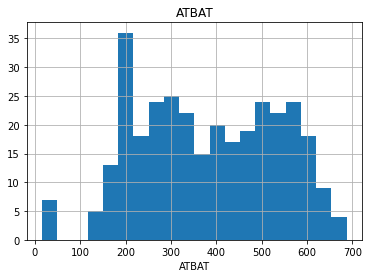

count   322.00
mean    101.02
std      46.45
min       1.00
5%       39.00
10%      45.10
20%      57.00
30%      70.00
40%      82.00
50%      96.00
60%     113.00
70%     128.70
80%     144.00
90%     163.00
95%     174.00
99%     210.79
max     238.00
Name: HITS, dtype: float64


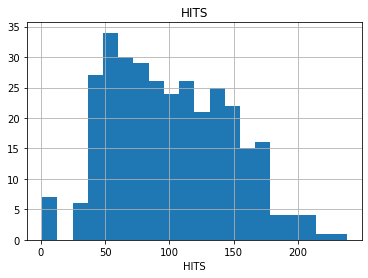

count   322.00
mean     10.77
std       8.71
min       0.00
5%        0.00
10%       1.00
20%       3.00
30%       5.00
40%       6.00
50%       8.00
60%      10.60
70%      14.00
80%      18.00
90%      24.00
95%      28.95
99%      33.00
max      40.00
Name: HMRUN, dtype: float64


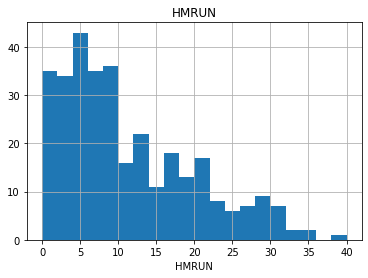

count   322.00
mean     50.91
std      26.02
min       0.00
5%       17.00
10%      20.10
20%      27.00
30%      33.00
40%      41.00
50%      48.00
60%      55.60
70%      66.00
80%      75.80
90%      89.00
95%      94.00
99%     107.79
max     130.00
Name: RUNS, dtype: float64


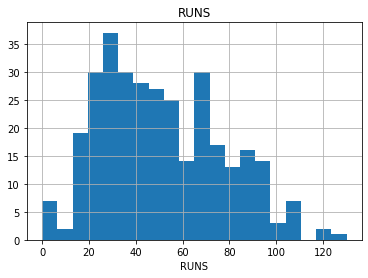

count   322.00
mean     48.03
std      26.17
min       0.00
5%       14.00
10%      19.00
20%      26.00
30%      30.00
40%      36.40
50%      44.00
60%      49.00
70%      58.00
80%      73.00
90%      86.00
95%      96.00
99%     112.37
max     121.00
Name: RBI, dtype: float64


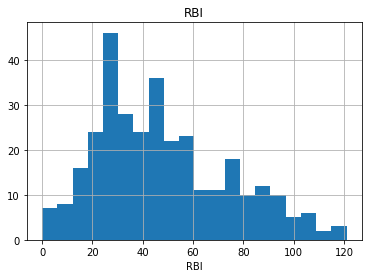

count   322.00
mean     38.74
std      21.64
min       0.00
5%       11.05
10%      15.00
20%      20.00
30%      24.00
40%      30.00
50%      35.00
60%      40.00
70%      48.70
80%      59.00
90%      69.90
95%      78.00
99%      93.58
max     105.00
Name: WALKS, dtype: float64


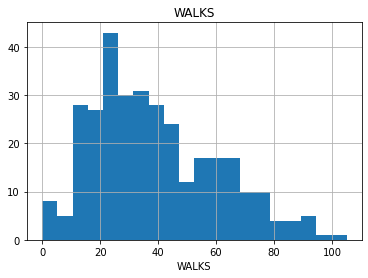

count   322.00
mean      7.44
std       4.93
min       1.00
5%        1.00
10%       2.00
20%       3.00
30%       4.00
40%       5.00
50%       6.00
60%       7.60
70%      10.00
80%      12.00
90%      15.00
95%      17.00
99%      19.79
max      24.00
Name: YEARS, dtype: float64


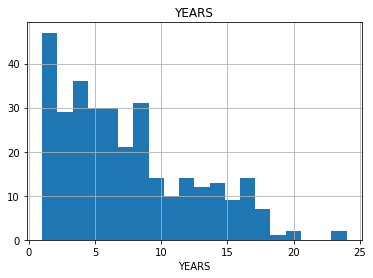

count     322.00
mean     2648.68
std      2324.21
min        19.00
5%        216.50
10%       342.20
20%       667.60
30%       963.40
40%      1402.20
50%      1928.00
60%      2654.00
70%      3365.00
80%      4483.00
90%      6123.40
95%      7125.60
99%      8749.97
max     14053.00
Name: CATBAT, dtype: float64


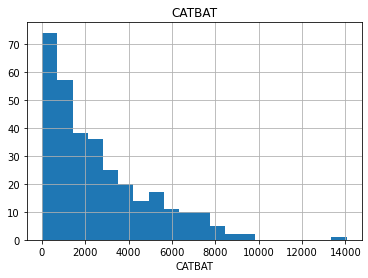

count    322.00
mean     717.57
std      654.47
min        4.00
5%        54.00
10%       86.00
20%      164.60
30%      238.00
40%      355.80
50%      508.00
60%      708.20
70%      911.10
80%     1229.20
90%     1659.60
95%     2017.15
99%     2500.34
max     4256.00
Name: CHITS, dtype: float64


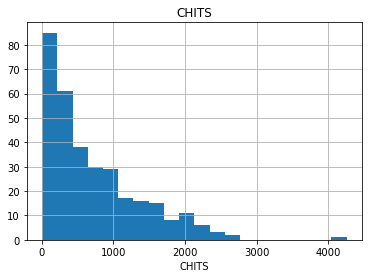

count   322.00
mean     69.49
std      86.27
min       0.00
5%        2.00
10%       4.00
20%      10.20
30%      16.30
40%      27.40
50%      37.50
60%      51.20
70%      72.40
80%     103.80
90%     194.90
95%     265.65
99%     373.12
max     548.00
Name: CHMRUN, dtype: float64


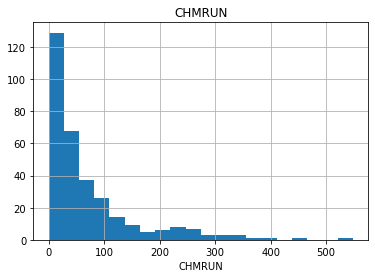

count    322.00
mean     358.80
std      334.11
min        1.00
5%        27.00
10%       38.10
20%       80.40
30%      117.30
40%      181.00
50%      247.00
60%      333.00
70%      443.40
80%      627.20
90%      895.70
95%     1032.30
99%     1174.37
max     2165.00
Name: CRUNS, dtype: float64


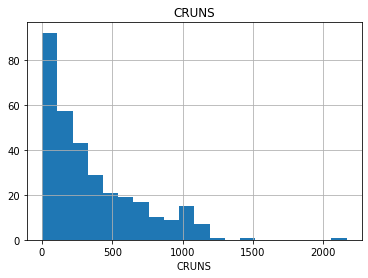

count    322.00
mean     330.12
std      333.22
min        0.00
5%        22.05
10%       34.10
20%       70.20
30%      106.30
40%      149.00
50%      220.50
60%      303.60
70%      379.10
80%      496.20
90%      861.60
95%     1071.75
99%     1310.85
max     1659.00
Name: CRBI, dtype: float64


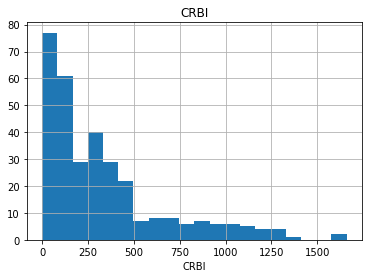

count    322.00
mean     260.24
std      267.06
min        0.00
5%        15.05
10%       30.10
20%       55.00
30%       82.00
40%      117.40
50%      170.50
60%      226.60
70%      300.70
80%      421.00
90%      643.90
95%      817.60
99%     1139.14
max     1566.00
Name: CWALKS, dtype: float64


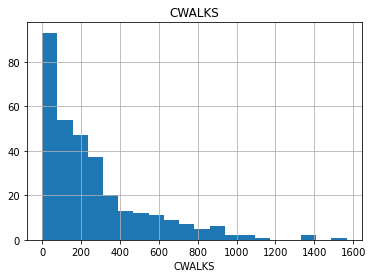

count    322.00
mean     288.94
std      280.70
min        0.00
5%        33.20
10%       62.20
20%       99.60
30%      132.00
40%      167.00
50%      212.00
60%      257.40
70%      303.00
80%      365.80
90%      685.60
95%      910.65
99%     1301.19
max     1378.00
Name: PUTOUTS, dtype: float64


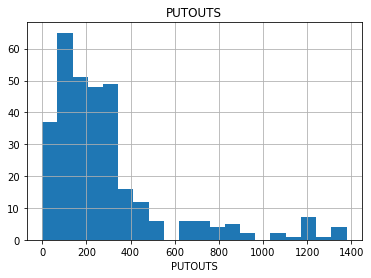

count   322.00
mean    106.91
std     136.85
min       0.00
5%        0.00
10%       2.00
20%       5.20
30%       9.00
40%      15.40
50%      39.50
60%      76.80
70%     134.80
80%     210.80
90%     353.30
95%     431.45
99%     478.16
max     492.00
Name: ASSISTS, dtype: float64


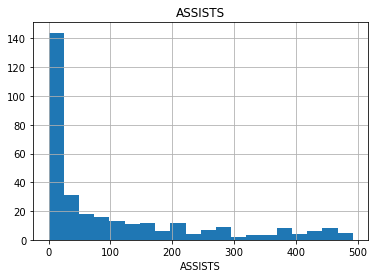

count   322.00
mean      8.04
std       6.37
min       0.00
5%        0.00
10%       1.00
20%       3.00
30%       4.00
40%       5.00
50%       6.00
60%       8.00
70%      10.00
80%      13.00
90%      17.00
95%      20.00
99%      25.79
max      32.00
Name: ERRORS, dtype: float64


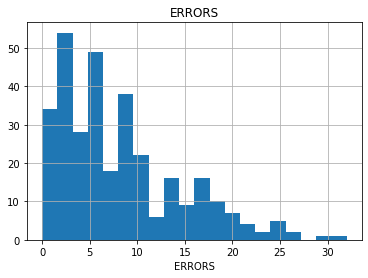

count    263.00
mean     535.93
std      451.12
min       67.50
5%        86.60
10%      100.00
20%      155.00
30%      221.00
40%      300.00
50%      425.00
60%      538.00
70%      700.00
80%      809.00
90%     1048.67
95%     1346.00
99%     2032.89
max     2460.00
Name: SALARY, dtype: float64


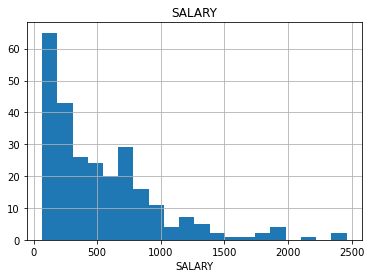

In [16]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [17]:
df_low_salary = df[df['SALARY'] < 200]
df_low_salary['ERRORS']

4       4
6       7
7       9
8      19
17     16
       ..
294    11
301    20
309     9
314    11
315    15
Name: ERRORS, Length: 69, dtype: int64

<AxesSubplot:xlabel='SALARY', ylabel='ERRORS'>

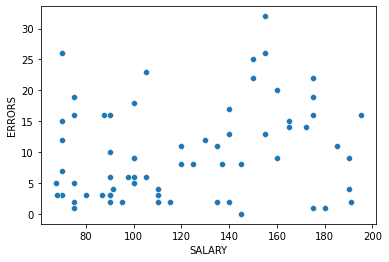

In [18]:
sns.scatterplot(x="SALARY", y="ERRORS", data=df_low_salary)

## Hedef Değişken Analizi

In [19]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [20]:
for col in num_cols:
    target_summary_with_num(df, "SALARY", col)

         ATBAT
SALARY        
67.50   181.00
68.00   209.00
70.00   248.60
75.00   236.40
80.00   399.00
...        ...
1940.00 514.00
1975.00 677.00
2127.33  20.00
2412.50 618.00
2460.00 495.00

[150 rows x 1 columns]


          HITS
SALARY        
67.50    41.00
68.00    54.00
70.00    57.40
75.00    58.20
80.00   102.00
...        ...
1940.00 144.00
1975.00 238.00
2127.33   1.00
2412.50 200.00
2460.00 151.00

[150 rows x 1 columns]


         HMRUN
SALARY        
67.50     1.00
68.00     3.00
70.00     3.20
75.00     3.00
80.00     3.00
...        ...
1940.00   0.00
1975.00  31.00
2127.33   0.00
2412.50  20.00
2460.00  17.00

[150 rows x 1 columns]


          RUNS
SALARY        
67.50    15.00
68.00    25.00
70.00    27.80
75.00    25.20
80.00    56.00
...        ...
1940.00  67.00
1975.00 117.00
2127.33   0.00
2412.50  98.00
2460.00  61.00

[150 rows x 1 columns]


           RBI
SALARY        
67.50    21.00
68.00    14.00
70.00    22.40
75.00    22.80
80.00    34.00
...        

In [21]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

In [22]:
for col in cat_cols:
    target_summary_with_cat(df, "SALARY", col)

LEAGUE
   TARGET_MEAN  Count  Ratio
A       542.00    175  54.35
N       529.12    147  45.65


DIVISION
   TARGET_MEAN  Count  Ratio
E       624.27    157  48.76
W       450.88    165  51.24


NEWLEAGUE
   TARGET_MEAN  Count  Ratio
A       537.11    176  54.66
N       534.55    146  45.34




## Korelasyon Analizi

In [23]:
df[num_cols].corr()

df.corr()

,ATBAT,HITS,HMRUN,RUNS,RBI,WALKS,YEARS,CATBAT,CHITS,CHMRUN,CRUNS,CRBI,CWALKS,PUTOUTS,ASSISTS,ERRORS,SALARY
ATBAT,1.00,0.97,0.59,0.91,0.82,0.67,0.05,0.24,0.25,0.24,0.27,0.24,0.17,0.32,0.35,0.35,0.39
HITS,0.97,1.00,0.56,0.92,0.81,0.64,0.04,0.23,0.26,0.20,0.26,0.23,0.15,0.31,0.32,0.31,0.44
HMRUN,0.59,0.56,1.00,0.65,0.86,0.48,0.12,0.22,0.22,0.49,0.26,0.35,0.23,0.28,-0.11,0.04,0.34
RUNS,0.91,0.92,0.65,1.00,0.80,0.73,0.00,0.19,0.20,0.23,0.25,0.21,0.18,0.28,0.22,0.24,0.42
RBI,0.82,0.81,0.86,0.80,1.00,0.62,0.15,0.29,0.31,0.44,0.32,0.39,0.25,0.34,0.11,0.19,0.45
WALKS,0.67,0.64,0.48,0.73,0.62,1.00,0.14,0.28,0.28,0.33,0.34,0.31,0.42,0.30,0.15,0.13,0.44
YEARS,0.05,0.04,0.12,0.00,0.15,0.14,1.00,0.92,0.90,0.73,0.88,0.87,0.84,-0.00,-0.08,-0.16,0.40
CATBAT,0.24,0.23,0.22,0.19,0.29,0.28,0.92,1.00,1.00,0.80,0.98,0.95,0.91,0.06,0.00,-0.07,0.53
CHITS,0.25,0.26,0.22,0.20,0.31,0.28,0.90,1.00,1.00,0.78,0.98,0.95,0.89,0.08,-0.00,-0.06,0.55
CHMRUN,0.24,0.20,0.49,0.23,0.44,0.33,0.73,0.80,0.78,1.00,0.82,0.93,0.80,0.11,-0.16,-0.14,0.52


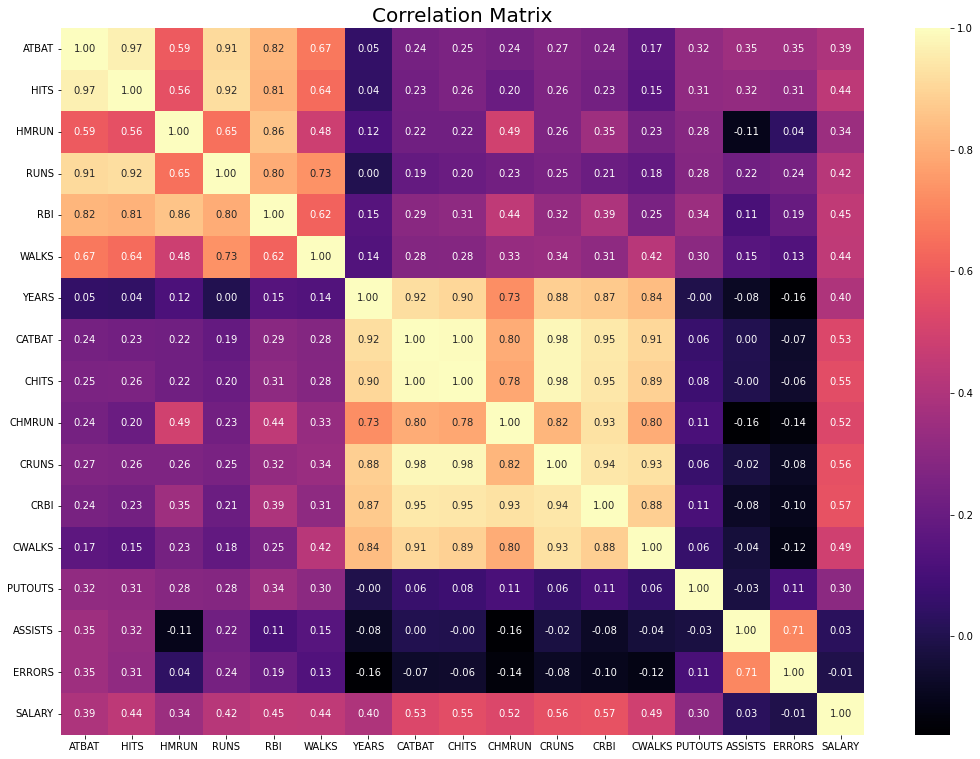

In [24]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

## Eksik Gözlem Analizi

In [25]:
df.isnull().any()

ATBAT        False
HITS         False
HMRUN        False
RUNS         False
RBI          False
WALKS        False
YEARS        False
CATBAT       False
CHITS        False
CHMRUN       False
CRUNS        False
CRBI         False
CWALKS       False
LEAGUE       False
DIVISION     False
PUTOUTS      False
ASSISTS      False
ERRORS       False
SALARY        True
NEWLEAGUE    False
dtype: bool

In [26]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [27]:
na_columns = missing_values_table(df, na_name=True)

        n_miss  ratio
SALARY      59  18.32


In [28]:
df["SALARY"].fillna(df["SALARY"].median(), inplace=True)

## Aykırı Değer Analizi

In [29]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [30]:
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

ATBAT False
HITS False
HMRUN False
RUNS False
RBI False
WALKS False
YEARS False
CATBAT False
CHITS False
CHMRUN False
CRUNS False
CRBI False
CWALKS False
PUTOUTS False
ASSISTS False
ERRORS False
SALARY False


## Base Model Kurulumu

In [31]:
dff = df.copy()

In [32]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [33]:
dff = one_hot_encoder(dff, cat_cols, drop_first=True)

In [34]:
y = dff["SALARY"]
X = dff.drop(["SALARY"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred = lin_model.predict(X_test)

lin_model.score(X_test, y_test)

0.37913394826121294

## Özellik Çıkarımı

In [35]:
# Major liginde 5 yıldan fazla oynayan ve oynamayan oyuncular
df.loc[df['YEARS'] > 5, 'NEW_YEARS_CAT'] = 'experienced'
df.loc[df['YEARS'] <= 5, 'NEW_YEARS_CAT'] = 'rookie'

In [36]:
# Oyuncunun kariyeri boyunca yaptığı başarılı işlerin oynadığı süreye göre ortalaması
df['NEW_CAREER_YEARS'] = (df['CATBAT'] + df['CHITS'] + df['CHMRUN'] + df['CRUNS'] + df['CRBI'] + df['CWALKS']) / df['YEARS']

In [37]:
# Oyuncunun home run puanı alabilme kabiliyeti
df.loc[df['HMRUN'] >= 10, 'NEW_HMRUN_CAT'] = 'homerunner'
df.loc[df['HMRUN'] < 10, 'NEW_HMRUN_CAT'] = 'not_homerunner'

In [38]:
# Oyuncunun 1986-1987 yıllarındaki vuruşlarını skora çevirme oranı
df['NEW_RUNS_ATBAT'] = df['RUNS'] / df['ATBAT']

In [39]:
# Oyuncunun 1986-1987 yıllarındaki net hata katkısı
df['NEW_ERRORS_RBI'] = df['WALKS'] - df['ERRORS']

In [40]:
# Oyuncunun yer aldığı bölge ve lig


In [41]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 25
cat_cols: 5
num_cols: 20
cat_but_car: 0
num_but_cat: 0


## Encoding

In [42]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [43]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['LEAGUE', 'DIVISION', 'NEWLEAGUE', 'NEW_YEARS_CAT', 'NEW_HMRUN_CAT']

In [44]:
for col in binary_cols:
    df = label_encoder(df, col)

In [45]:
cat_cols 

['LEAGUE', 'DIVISION', 'NEWLEAGUE', 'NEW_YEARS_CAT', 'NEW_HMRUN_CAT']

In [46]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [47]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

## Scaling

In [48]:
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,ATBAT,HITS,HMRUN,RUNS,RBI,WALKS,YEARS,CATBAT,CHITS,CHMRUN,...,ERRORS,SALARY,NEW_CAREER_YEARS,NEW_RUNS_ATBAT,NEW_ERRORS_RBI,LEAGUE_1,DIVISION_1,NEWLEAGUE_1,NEW_YEARS_CAT_1,NEW_HMRUN_CAT_1
0,0.41,0.27,0.03,0.23,0.24,0.13,0.00,0.02,0.01,0.00,...,0.62,0.15,0.41,0.44,0.05,0,0,0,1,1
1,0.45,0.34,0.18,0.18,0.31,0.37,0.57,0.24,0.20,0.13,...,0.31,0.17,0.37,0.33,0.39,1,1,1,0,1
2,0.69,0.54,0.45,0.51,0.60,0.72,0.09,0.11,0.11,0.11,...,0.44,0.17,0.93,0.59,0.71,0,1,0,1,0
3,0.72,0.59,0.50,0.50,0.64,0.35,0.43,0.40,0.37,0.41,...,0.09,0.18,0.83,0.56,0.44,1,0,1,0,0
4,0.45,0.36,0.25,0.30,0.35,0.29,0.04,0.03,0.02,0.02,...,0.12,0.01,0.30,0.52,0.36,1,0,1,1,0


## Modelleme

In [61]:
y = df["SALARY"]
X = df.drop(["SALARY"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

reg_model = LinearRegression().fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

reg_model.score(X_test, y_test)

0.46343096719855004

In [62]:
reg_model.coef_

array([-6.46154243e-01, -1.64022061e-02, -9.98905586e-02,  7.82764200e-01,
        9.30773754e-02,  1.20340284e-01, -4.10589361e-01, -1.11248921e+00,
        1.47769299e+00,  5.76668660e-02,  5.16899954e-01,  2.37988416e-01,
       -3.95672070e-01,  2.56648726e-02,  6.74776560e-02,  1.86772262e-02,
        5.90179808e-03, -6.35984216e-01,  1.16874355e-01,  1.52580956e-02,
       -3.88659063e-02, -1.46173491e-03, -1.38145240e-01, -2.95768352e-02])

In [63]:
reg_model.intercept_

0.5526643616944702